# Unit 5 - Financial Planning - Alternate Solution

In [125]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi

from datetime import datetime       # Import datetime function
from datetime import timedelta      # Import timedelta function

# from MCForecastTools import MCSimulation
from NewForecastTools import MCSimulation   # Import the latest MC Simulation to overcome performance issues and avoid certain warning messages appearing

import json

%matplotlib inline

In [126]:
# Load .env enviroment variables
if not load_dotenv():                                        # if the .env file can't be loaded...
    print("Error: could not load .env file - aborting")      #    print an error message 
    exit()                                                   #    end the script

## Part 1 - Personal Finance Planner

## Alternate solution using a dictionary for "Collect Crypto Prices Using the requests Library"

In [133]:
# Alternate solution using a dictionary to store our crypto portfolio. Note the absence of the coin id 1 or 1027 as we use call a different api that just needs the coin name

# Define a dictionary for my crypto portfolio
# the dictionary's schema is:
#    "name": {                 Unique Name Coin long name E.g. Bitcoin (as per alternative.me naming convention https://alternative.me/crypto/api/)
#        "symbol": "string",   Coin ticker symbol E.g. BTC
#        "holding": "float",   Quantity of coin currently held in my portfolio
#        "type": "string"      Type of asset: [crypto, stocks, bonds ]
#    },

my_portfolio = {
    "BTC": {
        "name":    "Bitcoin",
        "symbol":  "BTC",
        "holding": 1.2,
        "type":    "crypto"
    },
    "ETH": {
        "name":    "Ethereum",
        "symbol":   "ETH",
        "holding":  5.3,
        "type":     "crypto"
    },
    "AGG": {
        "name":    "iShares Core U.S. Aggregate Bond ETF",
        "symbol":  "AGG",
        "holding": 200,
        "type":    "bonds"
    },
    "SPY": {              
        "name":    "SPDR S&P 500 ETF",
        "symbol":  "SPY",
        "holding": 50,
        "type":    "stocks"
    },
   
} 

preferred_currency_code = "CAD"   # Set the preferred currency code to fetch from alternative.me

In [136]:
total_crypto_value = 0 # initialise the total portfolio value

for i in my_portfolio:
    if my_portfolio[i]["type"] != "crypto":   # Check if the asset is a crypto (we only do crypto in this cell)
        continue                              #   if not loop to the next asset
        
    # Get the coin details from my portfolio dictionary
    coin_name = my_portfolio[i]["name"]
    coin_symbol = my_portfolio[i]["symbol"]
    coin_holding = my_portfolio[i]["holding"]

    print(f"Fetching data for {coin_name}")
    url = f"https://api.alternative.me/v2/ticker/{coin_name}/?convert={preferred_currency_code}"  # build the url with the coin name and desired currency code. Note we don't need to coin id
                                                                                                  # api documentation is available here: https://alternative.me/crypto/api/
    
    #### Acknowledgement: requests.get exception handling code snippets from: https://stackoverflow.com/a/16511493
    try:        
        coin_data = requests.get(url, timeout=3).json()  # fetch the pricing data but timeout after 3 seconds if there is no response
    except requests.exceptions.RequestException as e:    # Handle system exceptions 
        raise SystemExit(e)
    
    metadata_error = coin_data["metadata"]["error"]
    if (metadata_error == None):                                                 # Check if no errors in the response from alternative.me
        # print(json.dumps(coin_data, indent=4))
        
        coin_id = list(coin_data["data"])[0]         # Get the first "id" value from the coin_data to then use to get the price
        
        coin_price = float(coin_data["data"][coin_id]["quotes"][preferred_currency_code]["price"])   # Convert the coin price into a float
        coin_value = coin_price * coin_holding     # Muliply the current coin price by our holding of the coin to get the value
        total_crypto_value += coin_value        # Add the value of the current coin to the total portfolio value

        time_stamp = coin_data["metadata"]["timestamp"]    # Additional information - grab the timestamp from the feed data which is in Unix epoch in seconds (eg 1544129220 )  
        date_time = datetime.fromtimestamp(time_stamp)     # ...and convert it to a human readable format

        # Show the date and time when the coin price was applicable, the coin name, symbol and holding value based on how many coins we have in the portfolio.
        # ...formatting the value with the thousands separator and 2 decimal places  
        print(f"The current value (as at {date_time}) of your {coin_name} ({coin_symbol}) in {preferred_currency_code} is ${coin_value:0,.2f}")
    else:
        raise SystemExit( f"alternative.me error response: {metadata_error}" )   #   raise an exception and exist as the total portfolio value won't be correct
    
print(f"The current total value of your crypto portfolio in {preferred_currency_code} is ${total_crypto_value:0,.2f}")    

Fetching data for Bitcoin
The current value (as at 2023-09-28 00:39:36) of your Bitcoin (BTC) in CAD is $42,804.16
Fetching data for Ethereum
The current value (as at 2023-09-28 00:39:38) of your Ethereum (ETH) in CAD is $11,518.06
The current total value of your crypto portfolio in CAD is $54,322.23


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [137]:
# Set Alpaca API key and secret
alpaca_api_key = os.environ.get('ALPACA_API_KEY')        # Fetch the api key from the .env file
alpaca_secret_key = os.environ.get('ALPACA_SECRET_KEY')  # Fetch the secret key from the .env file

# Set the Alpaca API version
alpaca_api_version = "v2"

# Set the base URL to Alpaca Market's trading environment.
# Could have read this from the .env file but Bootcamp's AlpacaMarkets_Installation-Guide.md in the 05-APIs/Supplemental folder setup instructions don't mention setting this up.
# According to https://github.com/alpacahq/alpaca-trade-api-python/#alpaca-environment-variables the default is the live site, so to be safe even though we are just fetchting prices, we
# hard code the base url to the paper trading site.
alpaca_base_url = "https://paper-api.alpaca.markets"     # Set the base url to Alpaca's paper trading environment

# Create the Alpaca API object
alpaca_api = tradeapi.REST(key_id=alpaca_api_key, secret_key=alpaca_secret_key, base_url=alpaca_base_url, api_version=alpaca_api_version)

In [138]:
type(alpaca_api)

alpaca_trade_api.rest.REST

In [139]:
# Format current date as ISO format
#
##################################################################################################
# NOTE TO ASSESSOR:
# Alpaca returned the following error when trying to retrieve the prices for the current date:
#    "APIError: your subscription does not permit querying data from the past 15 minutes"
#
# Despite the error message the delayed time frame specified in the alpaca_api.get_bars request
# needs to be at least 12 hours, not 15 minutes. Then it depends if the current date is a non-trading day
# or not (eg weekend), and if not no data is returned. I created a while loop in which the date is
# decremented by a day until it finds a day in which the stock was traded or gives up after a 
# maximum number of attempts
##################################################################################################

# Set the tickers
tickers = []                   # Initialise the tickers to an empty list
type_of_holding = []           # Set the corresponding class type
for security in my_portfolio:  # Iterate through my portfolio and...
    if ((my_portfolio[security]["type"] == "bonds") or (my_portfolio[security]["type"] == "stocks")):  # if its a stock or bond
        tickers.append(my_portfolio[security]["symbol"])            #  add the security's symbol to the ticker list
        type_of_holding.append(my_portfolio[security]["type"])      #   add the security's class type (bonds or stocks) to the type list

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# 4. Get the current closing prices for `SPY` and `AGG` using Alpaca's `get_bars()` function.

# Loop until we find valid trading data or abort after 100 attempts
# Initialise variables
attempt = 0                       # Initialise the attempt count
max_attempts = 100                # Initialise the maximum number of attempts after which we give up
df_portfolio = pd.DataFrame()     # Intialise the dataframe

while (attempt < max_attempts) and (len(df_portfolio) == 0):    # Loop until we find an active trading day or abort after the max attempts
    if attempt == 0:
        date_to_fetch = pd.Timestamp.now( tz="America/New_York").normalize()            # Get today's date on the first iteration of the loop
    else:
        date_to_fetch = date_to_fetch + timedelta(days=-1)                              # Decrement the date
        
    date_to_fetch_iso = date_to_fetch.isoformat()                                       # Convert the date to iso format needed by alpaca_api
    attempt += 1                                                                        # Increment the attempt counter

    # Get current closing prices for SPY and AGG and transform the function's response to a Pandas DataFrame
    df_portfolio = alpaca_api.get_bars( tickers, timeframe, start = date_to_fetch_iso, end = date_to_fetch_iso ).df    # Get the ticker data from alpaca_api
    
    if len(df_portfolio) == 0:                                                          # If no data returned...
        print(f"No price information available for {date_to_fetch_iso}")                #   show a warning message with the date

if len(df_portfolio) == 0:                                                              # Once we exit the loop check if we managed to get ticker data, if not
    print("Could not find data after {max_attempts} attempts" )                         #   show a warning message with the number of max attempts tried
else:
    display(df_portfolio.head())    # Display sample data                                 # otherwise show the sample data

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2023-09-27 04:00:00+00:00,94.47,94.5122,94.2020,94.225,1137528,5143,94.347337,AGG
2023-09-27 04:00:00+00:00,427.09,427.6700,425.8501,426.280,16173450,142272,426.799103,SPY


In [148]:
#### The following instructions are no longer required to access the specific ticker data ####
# Reorganize the DataFrame
# Separate ticker data
# Concatenate the ticker DataFrames

In [155]:
# 5. Pick the `SPY` and `AGG` close prices from the Alpaca's `get_bars()` DataFrame response and store them as Python variables.
# Pick AGG and SPY close prices
# Note to assessor: the following is from the starter code.
spy_close_price = float(df_portfolio[df_portfolio["symbol"] == "SPY"]["close"])
agg_close_price = float(df_portfolio[df_portfolio["symbol"] == "AGG"]["close"])

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $94.225
Current SPY closing price: $426.28


In [170]:
# 5. Pick the `SPY` and `AGG` close prices from the Alpaca's `get_bars()` DataFrame response and store them as Python variables.
# Pick AGG and SPY close prices

# Print AGG and SPY close prices
for symbol in tickers:
    close_price = float(df_portfolio[df_portfolio["symbol"] == symbol]["close"])
    my_portfolio[symbol]["close"] = close_price
    print(f"Current {symbol} closing price: ${close_price}")

Current AGG closing price: $94.225
Current SPY closing price: $426.28


In [172]:
# 6. Compute the value in dollars of the current amount of shares and print the results.
# Compute the current value of shares
total_shares_value = 0    # Initialise total value

for symbol in tickers:
    current_holding = my_portfolio[symbol]["holding"]                                                    # Get the stored current holding
    current_value = my_portfolio[symbol]["close"] * current_holding                                      # Multiply current holding by current close price   
    
    # Print current value of shares
    print(f"The current value of your {current_holding} {symbol} shares is ${current_value:0,.2f}")
    total_shares_value += current_value                                                                  # Add the current value to the total value of shares

The current value of your 200 AGG shares is $18,845.00
The current value of your 50 SPY shares is $21,314.00


### Savings Health Analysis

In [173]:
# Set monthly household income
monthly_income = 12000

# Create savings DataFrame
df_savings = pd.DataFrame([total_crypto_value, total_shares_value], index=["crypto", "shares"], columns=["amount"])

# Display savings DataFrame
display(df_savings)

,amount
crypto,54322.225386
shares,40159.000000


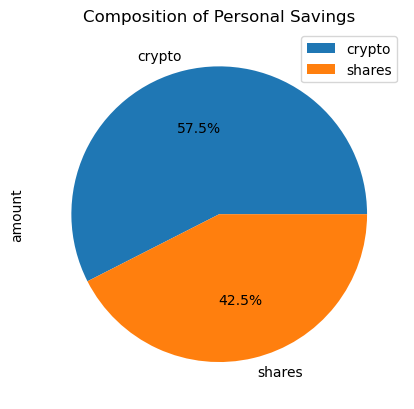

In [174]:
# Plot savings pie chart
savings_figure  = df_savings.plot.pie( y="amount", autopct = "%1.1f%%" , title = "Composition of Personal Savings" )

In [175]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings_amount = total_crypto_value + total_shares_value

# Validate saving health
if total_savings_amount > emergency_fund:                                # Check if total savings exceeds emergency fund, if so congratulate for exceeding
    display( "Congratulations on exceeding your financial goal!" )
elif total_savings_amount == emergency_fund:                               # Check if total savings equals emergency fund, if so congratulate for reaching
    display( "Congratulations on reaching your financial goal!" )
else: # total_savings_amount is < emergency_fund:                               #  else total savings are less than emergency fund,  so inform how much left to go
    amount_left = emergency_fund - total_savings_amount
    display( f"You need ${amount_left:0,.2f} to reach your financial goal." )

'Congratulations on exceeding your financial goal!'

## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [176]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2016-05-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-05-01', tz='America/New_York').isoformat()

In [177]:
# Get 5 years' worth of historical data for SPY and AGG
df_5y_historical_data = alpaca_api.get_bars( tickers, timeframe, start = start_date, end = end_date ).df

In [178]:
df_5y_historical_data.head()

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2016-05-02 04:00:00+00:00,110.74,110.7400,110.5200,110.605,3553939,15119,110.627199,AGG
2016-05-03 04:00:00+00:00,110.89,110.9450,110.7500,110.810,3044940,15662,110.865995,AGG
2016-05-04 04:00:00+00:00,110.91,110.9315,110.7595,110.860,2920608,13982,110.879063,AGG
2016-05-05 04:00:00+00:00,110.92,111.1600,110.8010,111.140,3008142,15707,111.028363,AGG
2016-05-06 04:00:00+00:00,111.12,111.1200,110.9700,110.970,2718710,12697,111.031967,AGG


Note to assessor: the script was refactored to reduce duplication. The following function was introduced as a result.

In [179]:
df_5y_historical_data

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2016-05-02 04:00:00+00:00,110.74,110.7400,110.5200,110.605,3553939,15119,110.627199,AGG
2016-05-03 04:00:00+00:00,110.89,110.9450,110.7500,110.810,3044940,15662,110.865995,AGG
2016-05-04 04:00:00+00:00,110.91,110.9315,110.7595,110.860,2920608,13982,110.879063,AGG
2016-05-05 04:00:00+00:00,110.92,111.1600,110.8010,111.140,3008142,15707,111.028363,AGG
2016-05-06 04:00:00+00:00,111.12,111.1200,110.9700,110.970,2718710,12697,111.031967,AGG
...,...,...,...,...,...,...,...,...
2021-04-26 04:00:00+00:00,417.44,418.2200,416.8111,417.610,51824860,295870,417.508245,SPY
2021-04-27 04:00:00+00:00,417.93,418.1400,416.3000,417.520,50297139,296300,417.481360,SPY
2021-04-28 04:00:00+00:00,417.81,419.0100,416.9000,417.400,50692781,330049,417.742098,SPY


In [180]:
# Run all of the Monte Carlo simulation analysis. 
#   Inputs:
#      forecast_years (number of years to forecast)
#      weightings (list of weightings of the portfolio)
#      type_of_holding (list of what type of security class the corresponding weighting is)
#      initial_investment (initial investment amount )
#
def monte_carlo_simulation_analysis( forecast_years, weightings, type_of_holding, initial_investment ):

    # Run the Monte Carlo simulation
    MC_sim = MCSimulation(
        portfolio_data = df_5y_historical_data,
        weights = weightings,
        num_simulation = 500,
        num_trading_days = 252 * forecast_years
    )
    
    # Printing the simulation input data
    print("Daily returns")
    print(MC_sim.daily_returns.head(), "\n")
    
    # Running a Monte Carlo simulation to forecast cumulative returns
    print("Simulation cumulative returns")
    print(MC_sim.calc_cumulative_return(), "\n")
    
    # Plot simulation outcomes
    line_plot = MC_sim.plot_simulation()
    print()

    # Plot probability distribution and confidence intervals
    dist_plot = MC_sim.plot_distribution()
    print()
    
    # Fetch summary statistics from the Monte Carlo simulation results
    cr_table = MC_sim.summarize_cumulative_return()

    # Print summary statistics
    print("Summary statistics")
    print(cr_table)
    print()
    
    # Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of the initial investment
    ci_lower = round(cr_table["95% CI Lower"]*initial_investment,2)
    ci_upper = round(cr_table["95% CI Upper"]*initial_investment,2)

    # Print a summary of input parameters and the confidence indications
    print ("Confidence Interval Analysis")
    print("With a portfolio consisting of ", end="" )           # Show the portfolio composition by asset type
    for i in range( 0, len(weightings) ):
        if i == len(weightings) - 1:                            # joining the last two asset types with an "and"
            print(" and ", end="" )
        elif i > 0:
            print(", ", end="" )                                # separating other asset types with a comma
        print(f"{weightings[i]*100:0}% {type_of_holding[i]}", end="" )

    # Print results
    print(f", there is a 95% chance that an initial investment of ${initial_investment:0,.2f} in the portfolio"
          f" over the next {forecast_years} years will end within in the range of"
          f" ${ci_lower:0,.2f} and ${ci_upper:0,.2f}")    

### Retirement Analysis

### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [181]:
monte_carlo_simulation_analysis(30, [0.40, 0.60], type_of_holding, 20000) # Run simulation for 30 years, 40/60% mix and 20k initial investment

Daily returns
symbol                          AGG       SPY
timestamp                                    
2016-05-03 04:00:00+00:00  0.001853 -0.008707
2016-05-04 04:00:00+00:00  0.000451 -0.005574
2016-05-05 04:00:00+00:00  0.002526 -0.000195
2016-05-06 04:00:00+00:00 -0.001530  0.003659
2016-05-09 04:00:00+00:00  0.000631  0.000822 

Simulation cumulative returns
            0          1          2          3          4          5    \
0      1.003578   0.993934   0.990080   0.994212   0.990837   0.999252   
1      1.004345   0.995962   0.989691   0.989898   0.994202   1.007764   
2      1.002391   0.997489   0.994412   0.992284   1.001979   1.003907   
3      1.001416   0.998032   0.975871   1.003268   1.009027   1.013313   
4      1.002978   1.004363   0.974198   1.001610   1.014437   1.010285   
...         ...        ...        ...        ...        ...        ...   
7554  68.963797  22.390777  52.640511  17.963367  37.263021  25.291495   
7555  69.187872  22.325494  52.265514  1

### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [182]:
monte_carlo_simulation_analysis(30, [0.40, 0.60], type_of_holding, 20000*1.5) # Run simulation for 30 years, 40/60% mix and 30k initial investment

Daily returns
symbol                          AGG       SPY
timestamp                                    
2016-05-03 04:00:00+00:00  0.001853 -0.008707
2016-05-04 04:00:00+00:00  0.000451 -0.005574
2016-05-05 04:00:00+00:00  0.002526 -0.000195
2016-05-06 04:00:00+00:00 -0.001530  0.003659
2016-05-09 04:00:00+00:00  0.000631  0.000822 

Simulation cumulative returns
             0          1          2           3         4          5    \
0       0.997016   0.998297   1.002156    1.013731  1.007589   0.993966   
1       0.988490   1.005273   1.003247    1.013719  1.013897   0.987669   
2       0.980906   1.004096   1.000555    1.018161  1.021369   0.994313   
3       0.979422   1.000441   1.007706    1.023659  1.038402   0.988397   
4       0.979347   0.997780   1.000731    1.025550  1.043020   0.980852   
...          ...        ...        ...         ...       ...        ...   
7554  110.872248  18.482823  12.271304  131.267050  7.742135  68.040780   
7555  111.345759  18.496937  12.

## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [183]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
monte_carlo_simulation_analysis(5, [0.20, 0.80], type_of_holding, 20000) # Run simulation for 5 years, 20/80% mix and 20k initial investment

Daily returns
symbol                          AGG       SPY
timestamp                                    
2016-05-03 04:00:00+00:00  0.001853 -0.008707
2016-05-04 04:00:00+00:00  0.000451 -0.005574
2016-05-05 04:00:00+00:00  0.002526 -0.000195
2016-05-06 04:00:00+00:00 -0.001530  0.003659
2016-05-09 04:00:00+00:00  0.000631  0.000822 

Simulation cumulative returns
           0         1         2         3         4         5         6    \
0     0.998029  1.002112  0.998386  1.000021  0.999707  0.997044  0.999912   
1     1.006017  1.004980  0.998993  0.993112  1.000723  1.003075  0.996261   
2     0.998871  1.011591  0.991186  0.995735  0.994017  1.016310  0.998442   
3     1.001746  1.013125  0.996429  0.994002  0.988363  1.024930  1.006559   
4     0.992788  1.023338  1.002216  0.983789  0.993292  1.027249  1.008097   
...        ...       ...       ...       ...       ...       ...       ...   
1254  3.379394  1.318478  1.901225  1.384833  1.540072  1.475795  1.285030   
1255  3.

### Ten Years Retirement Option

In [184]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
monte_carlo_simulation_analysis(10, [0.20, 0.80], type_of_holding, 20000) # Run simulation for 10 years, 20/80% mix and 20k initial investment

Daily returns
symbol                          AGG       SPY
timestamp                                    
2016-05-03 04:00:00+00:00  0.001853 -0.008707
2016-05-04 04:00:00+00:00  0.000451 -0.005574
2016-05-05 04:00:00+00:00  0.002526 -0.000195
2016-05-06 04:00:00+00:00 -0.001530  0.003659
2016-05-09 04:00:00+00:00  0.000631  0.000822 

Simulation cumulative returns
           0         1         2         3         4         5          6    \
0     0.994086  0.998177  1.003258  0.999927  0.995933  1.003527   1.004831   
1     0.990254  1.006095  1.012744  1.001443  0.999797  0.997117   1.004225   
2     0.989729  1.002208  1.016066  1.000825  1.000428  1.002731   1.013187   
3     0.986706  0.999867  1.022913  1.011553  0.997038  0.999150   1.017682   
4     0.983350  1.010516  1.022480  1.015253  1.004675  1.002969   1.014798   
...        ...       ...       ...       ...       ...       ...        ...   
2514  3.005951  1.948723  2.363491  2.843978  1.982728  4.386864  10.333471   


---